## Fetch Catalog Technical Challenge - Andrew Byrnes

This notebook preps the provided .csv files and uploads them to a SQLite database.  
I chose SQLite for this challenge because it is lightweight and lends itself well to sharing.  
SQLite's flexible typing rules could be a liability for a database that would be continually updated and primarily used for analysis. For that usecase I would choose something that more strictly follows SQL standard.

### Data Sources 
- Catalog Analyst Technical Challenge.html: technical challenge instructions
- brand_codes.csv, brands.csv, cpgs.csv, products.csv: raw data files provided for completition of the challenge

### Changes
- 08-30-2022 : Started project
- 08-31-2022 : First pass at data, Converted data types
- 09-01-2022 : Created SQLite db
- 09-08-2022 : Created realted_brands table
- 09-09-2022 : rerunning notebook to validate prior to submitting


In [9]:
import pandas as pd
from ast import literal_eval
from pathlib import Path
import os
from datetime import datetime
import sqlite3
import re

### File Locations

In [10]:
in_brand_codes = Path.cwd() / "data" / "raw" / "brand_codes.csv"
in_brands = Path.cwd() / "data" / "raw" / "brands.csv"
in_cpgs = Path.cwd() / "data" / "raw" / "cpgs.csv"
in_products = Path.cwd() / "data" / "raw" / "products.csv"
db_path = Path.cwd() / "data" / "processed" / "catalog.db"

### Drop database if exists

In [11]:
if os.path.exists(db_path):
    os.remove(db_path)
    print("The file has been deleted successfully")
else:
    print("The file does not exist!")

The file does not exist!


### Formatting

In [12]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

### Data Frames 

In [13]:
df_brand_codes = pd.read_csv(in_brand_codes)
df_brands = pd.read_csv(in_brands)
df_cpgs = pd.read_csv(in_cpgs)
df_products = pd.read_csv(in_products)

### Clean Up Data Types

In [14]:
df_brand_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         263 non-null    object
 1   brandcode  260 non-null    object
 2   cpg_id     263 non-null    object
dtypes: object(3)
memory usage: 6.3+ KB


In [15]:
df_brand_codes

,id,brandcode,cpg_id
0,61128d4f3ae9e26706435fb7,GEORGE'S QUICK'N EAT,61128ccac17d1b474029efbc
1,6155c2704878a47d241444a6,CLIF THINS,613f75d3276007374fd751b1
2,61004cd89ac8f0018ac10ac6,TICONDEROGA,61004cc09ac8f0018ac10ac5
3,60f833ab251e8b16355ee9bd,SONIC,60f8338b251e8b16355ee9bc
4,60f8268e251e8b16355ee9bb,WENDYS,60f8265fed274e67f26397c7
5,610ad829c17d1b474029efb8,CHICK FIL A,610ad7fd3ae9e26706435faf
6,6113ed75a20afa07cd83b26c,KODIAK CAKES FLAPJACK & WAFFLE MIX 2,6113ebf73dbdab4ae0413c7d
7,616606295c23681bead7b19d,LITTLE CAESARS,6166058ee9b64e09dda400da
8,610ae9e63ae9e26706435fb1,TACO BELL REST,610ae9113ae9e26706435fb0
9,610ac980c17d1b474029efb7,JACK IN THE BOX,610ac9473ae9e26706435fae


NOTES: df_brand_codes: dtypes are ok, 3 null values in brandcode column

In [16]:
df_brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             262 non-null    object 
 1   category       253 non-null    object 
 2   createdate     207 non-null    float64
 3   updatedate     262 non-null    int64  
 4   name           262 non-null    object 
 5   romancetext    180 non-null    object 
 6   websiteurl     210 non-null    object 
 7   imageurl       172 non-null    object 
 8   relatedbrands  17 non-null     object 
dtypes: float64(1), int64(1), object(7)
memory usage: 18.5+ KB


In [17]:
df_brands

,id,category,createdate,updatedate,name,romancetext,websiteurl,imageurl,relatedbrands
0,616746f2e9b64e09dda400dc,Grocery,1.634158e+12,1634158969025,7NOW,"The 7‑Eleven brand is known and loved around the world, and our iconic products are a big part of the American culture. And although we’ve grown significantly over the years, our focus stays fixed on making life easier for customers.",https://www.7now.com/home,NaN,NaN
1,6155c27e4878a47d241444a7,Snacks,1.633010e+12,1633010302330,Clif Bar Duos,NaN,NaN,NaN,NaN
2,614114de49868a649825d21a,Restaurants,1.631655e+12,1631655134332,Restaurant & Rewards,NaN,NaN,NaN,NaN
3,6141165cfb6ebf129a6ac68b,Restaurants,1.631656e+12,1632235682300,Restaurants & Rewards,"Our Restaurants & Rewards celebration is live, now through 9/26. There are plenty of reasons to get excited and dig in, including earning an extra 25 points on all restaurant receipts, Special Offers from popular restaurants, and we’ll be giving away millions of points in prizes.",NaN,https://cdn.images.fetchrewards.com/brands/6f834c849c749ad21c6fbd2c8ce60dd5ea20c5d3.png,"{611e69752b434d3de53f42bb,60db56dfc1c99202a7cbef58,60db33bdc1c99202a7cbef56,60e87288168e743191c75991}"
4,5332f5fbe4b03c9a25efd0bb,Beverages,NaN,1633367733848,Mountain Dew,Do the Dew.,http://www.mountaindew.com/products/mtn-dew,http://cdn.images.fetchrewards.com/brands/dad6c1b690e160ba3419b26286b9b65efe94778f.png,{615b36aa4878a47d241444a9}
5,5bd2011f90fa074576779a17,Baby,1.540490e+12,1634299644970,Huggies,"The first moment you hug your baby, the rest of the world slowly melts away. Huggies understands there is nothing more powerful than that moment and every moment that follows. That's why they designed their diapers to feel the same way. Trust Huggies diapers and wipes through every family moment.",https://www.huggies.com/en-us/#expecting-mom,http://cdn.images.fetchrewards.com/brands/7772c20e320131a14ba0c4bb2b108cce36b5cf93.png,"{5da603a71dda2c3e1416ae82,5332f775e4b03c9a25efd127,5c112616315a241ba1716511,5bd201a990fa074576779a19}"
6,5332f774e4b03c9a25efd126,Health & Wellness,NaN,1627657763837,Fiber One,Fiber One is the perfect treat for those who are snacking by their own rules. It’s a moment of “me time pleasure” that stands apart from a world of so many shoulds and should nots.,https://www.fiberone.com,https://cdn.images.fetchrewards.com/brands/f96863b10f31fafb53410d61271a68e1a85a12b7.png,"{5d6415d5a3a018514994f429,5daf2a6b1dda2c3e1416ae91,585a970ee4b03e62d1ce0e91}"
7,5daf33e71dda2c3e1416ae93,Snacks,1.571763e+12,1628197399531,LARABAR,"LÄRABAR products are just a simple blend of just 2-9 real ingredients like whole nuts and fruits – and sometimes delicious chocolate chips! No artificial flavors, preservatives or sweeteners. Simply put, it's food made from food.",https://www.larabar.com/our-products,http://cdn.images.fetchrewards.com/brands/6327b065fe873dd56e0605fe549cc6837e2b06b8.png,"{5d66d9016d5f3b6188d4f04a,5daf3507a60b87376833e35c,592486bfe410d61fcea3d139}"
8,5e6bb6fd5d56cb1295f59ab8,"Beer, Hard Cider & Seltzer",1.584118e+12,1628803325172,Keylightful,Keylightful brings together a refreshingly sweet duo of raspberry and lime twisted with a splash of your always smooth go-to beer.,https://www.keystonelight.com/av?url=https://www.keystonelight.com/,http://cdn.images.fetchrewards.com/brands/9bc444e88baa0f612bbdf74efdfd68fbe5ecb648.png,{57e5810ce4b0ac389136a307}
9,5fed4cfbac99f041f08015a7,Health & Wellness,1.609387e+12,1634243697239,Lotrimin®,"Lotrimin® is the #1 Antifungal OTC Brand, and offers a range of products to cure most athlete’s foot, jock itch and ringworm, as well as a line of products to prevent most athlete’s foot. When you choose Lotrimin, you can Go with Confidence!",https://www.lotrimin.com/,https://cdn.images.fetchrewards.com/brands/0ad4eeb82aaa134ece4fa1fa75d5d3c13c4e520c.png,"{5da605dc1dda2c3e1416ae83,5ea302afac99f064b8c2740a,5e7cc6ef4f392912df7c86d1}"


NOTES: df_brands - dtypes ok. id, name, updatedate are the only non-null columns

~~**to-do**: for optional question 10, add two new columns to convert the updatedate and createdate values to a format that better aligns with the rest of this schema (cpgs.updated_at : 2022-07-08 12:36:42.733)~~

In [18]:
updatedate_ts = pd.to_datetime(df_brands['updatedate'], unit='ms')
df_brands['updatedate_ts'] = updatedate_ts

createdate_ts = pd.to_datetime(df_brands['createdate'], unit='ms').round('1ms')
df_brands['createdate_ts'] = createdate_ts


df_brands

,id,category,createdate,updatedate,name,romancetext,websiteurl,imageurl,relatedbrands,updatedate_ts,createdate_ts
0,616746f2e9b64e09dda400dc,Grocery,1.634158e+12,1634158969025,7NOW,"The 7‑Eleven brand is known and loved around the world, and our iconic products are a big part of the American culture. And although we’ve grown significantly over the years, our focus stays fixed on making life easier for customers.",https://www.7now.com/home,NaN,NaN,2021-10-13 21:02:49.025,2021-10-13 20:52:02.512
1,6155c27e4878a47d241444a7,Snacks,1.633010e+12,1633010302330,Clif Bar Duos,NaN,NaN,NaN,NaN,2021-09-30 13:58:22.330,2021-09-30 13:58:22.330
2,614114de49868a649825d21a,Restaurants,1.631655e+12,1631655134332,Restaurant & Rewards,NaN,NaN,NaN,NaN,2021-09-14 21:32:14.332,2021-09-14 21:32:14.332
3,6141165cfb6ebf129a6ac68b,Restaurants,1.631656e+12,1632235682300,Restaurants & Rewards,"Our Restaurants & Rewards celebration is live, now through 9/26. There are plenty of reasons to get excited and dig in, including earning an extra 25 points on all restaurant receipts, Special Offers from popular restaurants, and we’ll be giving away millions of points in prizes.",NaN,https://cdn.images.fetchrewards.com/brands/6f834c849c749ad21c6fbd2c8ce60dd5ea20c5d3.png,"{611e69752b434d3de53f42bb,60db56dfc1c99202a7cbef58,60db33bdc1c99202a7cbef56,60e87288168e743191c75991}",2021-09-21 14:48:02.300,2021-09-14 21:38:36.559
4,5332f5fbe4b03c9a25efd0bb,Beverages,NaN,1633367733848,Mountain Dew,Do the Dew.,http://www.mountaindew.com/products/mtn-dew,http://cdn.images.fetchrewards.com/brands/dad6c1b690e160ba3419b26286b9b65efe94778f.png,{615b36aa4878a47d241444a9},2021-10-04 17:15:33.848,NaT
5,5bd2011f90fa074576779a17,Baby,1.540490e+12,1634299644970,Huggies,"The first moment you hug your baby, the rest of the world slowly melts away. Huggies understands there is nothing more powerful than that moment and every moment that follows. That's why they designed their diapers to feel the same way. Trust Huggies diapers and wipes through every family moment.",https://www.huggies.com/en-us/#expecting-mom,http://cdn.images.fetchrewards.com/brands/7772c20e320131a14ba0c4bb2b108cce36b5cf93.png,"{5da603a71dda2c3e1416ae82,5332f775e4b03c9a25efd127,5c112616315a241ba1716511,5bd201a990fa074576779a19}",2021-10-15 12:07:24.970,2018-10-25 17:45:03.500
6,5332f774e4b03c9a25efd126,Health & Wellness,NaN,1627657763837,Fiber One,Fiber One is the perfect treat for those who are snacking by their own rules. It’s a moment of “me time pleasure” that stands apart from a world of so many shoulds and should nots.,https://www.fiberone.com,https://cdn.images.fetchrewards.com/brands/f96863b10f31fafb53410d61271a68e1a85a12b7.png,"{5d6415d5a3a018514994f429,5daf2a6b1dda2c3e1416ae91,585a970ee4b03e62d1ce0e91}",2021-07-30 15:09:23.837,NaT
7,5daf33e71dda2c3e1416ae93,Snacks,1.571763e+12,1628197399531,LARABAR,"LÄRABAR products are just a simple blend of just 2-9 real ingredients like whole nuts and fruits – and sometimes delicious chocolate chips! No artificial flavors, preservatives or sweeteners. Simply put, it's food made from food.",https://www.larabar.com/our-products,http://cdn.images.fetchrewards.com/brands/6327b065fe873dd56e0605fe549cc6837e2b06b8.png,"{5d66d9016d5f3b6188d4f04a,5daf3507a60b87376833e35c,592486bfe410d61fcea3d139}",2021-08-05 21:03:19.531,2019-10-22 16:52:55.173
8,5e6bb6fd5d56cb1295f59ab8,"Beer, Hard Cider & Seltzer",1.584118e+12,1628803325172,Keylightful,Keylightful brings together a refreshingly sweet duo of raspberry and lime twisted with a splash of your always smooth go-to beer.,https://www.keystonelight.com/av?url=https://www.keystonelight.com/,http://cdn.images.fetchrewards.com/brands/9bc444e88baa0f612bbdf74efdfd68fbe5ecb648.png,{57e5810ce4b0ac389136a307},2021-08-12 21:22:05.172,2020-03-13 16:38:21.394
9,5fed4cfbac99f041f08015a7,Health & Wellness,1.609387e+12,1634243697239,Lotrimin®,"Lotrimin® is the #1 Antifungal OTC Brand, and offers a range of products to cure most athlete’s foot, jock itch an

In [19]:
df_cpgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          300 non-null    object
 1   partner     256 non-null    object
 2   name        300 non-null    object
 3   updated_at  300 non-null    object
dtypes: object(4)
memory usage: 9.5+ KB


In [20]:
df_cpgs

,id,partner,name,updated_at
0,62c4e6e42a605c32f108119b,True,Johnson & Johnson,2022-07-08 12:36:42.733
1,62c4dc3c2a605c32f1081199,True,Ferrero Group,2022-07-08 12:36:42.733
2,62bdbc3e2a605c32f1081196,True,Dole Packaged Foods,2022-07-08 12:36:42.733
3,62ba9ba22a605c32f1081193,NaN,Sabrosura Foods,2022-07-08 12:36:42.733
4,62bb25ecaa7ca6249b59e7f0,True,The JM Smucker Company,2022-07-08 12:36:42.733
5,62b9ec3baa7ca6249b59e7ec,False,Instacart,2022-07-08 12:36:42.733
6,62b3fddacbf3d978d9ed32f0,NaN,Gopuff,2022-07-08 12:36:42.733
7,62b323f563c8a23086f9a15c,False,Soylent,2022-07-08 12:36:42.733
8,62acc9df3ef67320dff1cfc9,NaN,Spangler Candy Company,2022-07-08 12:36:42.733
9,62aca8943ef67320dff1cfc8,NaN,Against the Grain Gourmet,2022-07-08 12:36:42.733


NOTES: df_cpgs - some nulls in partner column 

~~**to-do:** convert partner to bool allowing nulls, updated_at to datetime64~~

In [21]:
df_cpgs.groupby('partner', dropna=False).size()

partner
False    160
True      96
NaN       44
dtype: int64

In [23]:
updated_to_datetime = pd.to_datetime(df_cpgs['updated_at'])
df_cpgs['updated_at'] = updated_to_datetime

bool_w_null = df_cpgs['partner'].astype("boolean")
df_cpgs['partner'] = bool_w_null

df_cpgs.info()
df_cpgs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          300 non-null    object        
 1   partner     256 non-null    boolean       
 2   name        300 non-null    object        
 3   updated_at  300 non-null    datetime64[ns]
dtypes: boolean(1), datetime64[ns](1), object(2)
memory usage: 7.7+ KB


,id,partner,name,updated_at
0,62c4e6e42a605c32f108119b,True,Johnson & Johnson,2022-07-08 12:36:42.733
1,62c4dc3c2a605c32f1081199,True,Ferrero Group,2022-07-08 12:36:42.733
2,62bdbc3e2a605c32f1081196,True,Dole Packaged Foods,2022-07-08 12:36:42.733
3,62ba9ba22a605c32f1081193,<NA>,Sabrosura Foods,2022-07-08 12:36:42.733
4,62bb25ecaa7ca6249b59e7f0,True,The JM Smucker Company,2022-07-08 12:36:42.733
5,62b9ec3baa7ca6249b59e7ec,False,Instacart,2022-07-08 12:36:42.733
6,62b3fddacbf3d978d9ed32f0,<NA>,Gopuff,2022-07-08 12:36:42.733
7,62b323f563c8a23086f9a15c,False,Soylent,2022-07-08 12:36:42.733
8,62acc9df3ef67320dff1cfc9,<NA>,Spangler Candy Company,2022-07-08 12:36:42.733
9,62aca8943ef67320dff1cfc8,<NA>,Against the Grain Gourmet,2022-07-08 12:36:42.733


In [24]:
df_cpgs.groupby('partner', dropna=False).size()

partner
False    160
True      96
<NA>      44
dtype: int64

In [25]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   barcode       1500 non-null   int64 
 1   brand         1500 non-null   object
 2   product_name  1500 non-null   object
 3   size          1176 non-null   object
 4   category_1    1500 non-null   object
 5   category_2    1500 non-null   object
 6   category_3    1498 non-null   object
dtypes: int64(1), object(6)
memory usage: 82.2+ KB


In [26]:
df_products

,barcode,brand,product_name,size,category_1,category_2,category_3
0,70923002009,TERRO,"TERRO READY-TO-USE LIQUID ANT KILLER, 2 OZ",NaN,HOUSEHOLD,INSECT & PEST CONTROL,INSECT & PEST CONTROL
1,764302265122,SHEA MOISTURE,SHEA MOISTURE ANTI FRIZZ HAIR CONDITIONER LIQUID THICK WAVY HAIR RP 10.3 OZ,10 OZ,DAILY HAIR CARE,WASH & CARE,REGULAR/BASIC CONDITIONERS
2,79400267238,CLEAR,CLEAR SCALP AND HAIR BEAUTY THERAPY TOTAL CA NOURISHING SHAMPOO LIQUID PLASTIC BOTTLE RP 21.9 OZ - 0079400267231,21 OZ,DAILY HAIR CARE,WASH & CARE,SHAMPOO X DRY
3,8717644013045,AXE,AXE AFRICA DEODORANT REGULAR AEROSOL SPRAY RP 5 OZ,5 OZ,APDEO,BODY SPRAY/MISTS,BODY SPRAY/MISTS
4,800897115609,NYX PROFESSIONAL MAKEUP,NYX PROFESSIONAL MAKEUP ROUND EXTRA CREAMY ROUND LIPSTICK,1 CT,COLOR COSMETICS,LIP,LIPSTICK
5,50428617236,CVS,SKIN PROTECTANT ADVANCED SCAR GEL,NaN,FACIAL SKIN CARE,FACIAL TREATMENT,FACIAL TREATMENT
6,41000004384,LIPTON,LIPTON STRAWBERRY WTRMELON ICED HERBAL TEA TEA CAFFEINE FREE 2 OZ - 0041000004382,NaN,TOTAL TEA,LEAF TEA,SPECIALTY
7,835229000209,ABSOLUT,ABSOLUT BL 80 24/375 US,375 ML,TOTAL SPIRITS,VODKA,NON FLAVORED
8,70470271095,YOPLAIT,"YOPLAIT LIGHT NON-FAT YOGURT - VANILLACHERRY, 6OZ",1 PACK,YOGURT,REFRIGERATED YOGURT,TRD SNGL SRV & MPK
9,16500587439,ONE A DAY,ONE A DAY 50+ ADVANTAGE ADULT MULTIVITAMINS WOMENS MATURE WOMENS TABS/CAPS 40 CT 40 CT RP - 1650058743,40 CT,HEALTH & WELLNESS,NUTRITIONALS,ADULT MULTIVITAMINS


NOTES: dtypes ok, only columns with nulls are size and category_3

~~**to-do** Is the barcode column unique?~~ yes - candidate for unique constraint

### Create Database

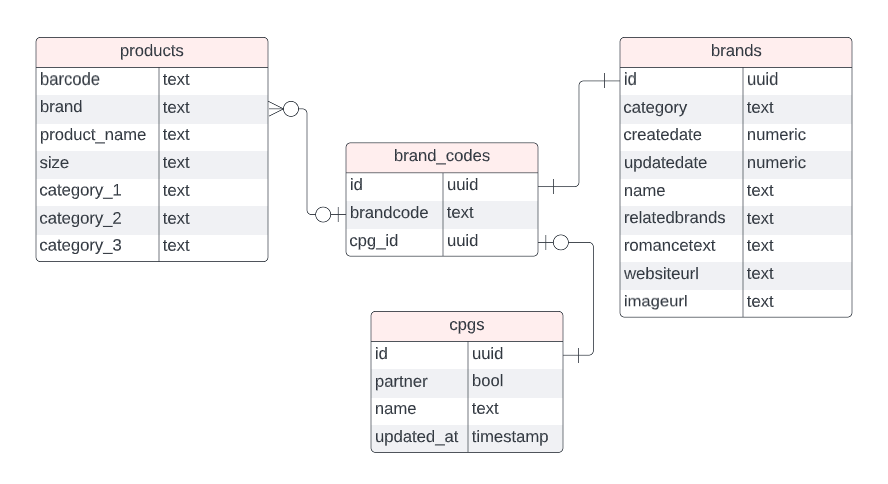
Provided schema 

NOTES:  
    brand_codes.brandcode - zero or one TO zero or many - products.brand  
    brand_codes.id - one TO on - brands.id  
    brandcodes.cpg_id - zero or one TO one - cpgs.id

In [27]:
# create products table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS products')

c.execute("""CREATE TABLE IF NOT EXISTS products (
        barcode text UNIQUE,
        brand text,
        product_name text, 
        size text,
        category_1 text,
        category_2 text,
        category_3 text
    )""")

df_products.to_sql('products', conn, if_exists='append', index=False)

conn.commit()
conn.close()

In [28]:
# create cpgs table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS cpgs')

c.execute("""CREATE TABLE IF NOT EXISTS cpgs (
        id uuid PRIMARY KEY,
        partner bool,
        name text, 
        updated_at timestamp
    )""")

df_cpgs.to_sql('cpgs', conn, if_exists='append', index=False)

conn.commit()
conn.close()

**to-do:** confirm that partner performs as boolean, may need to convert to ints 0 1

In [29]:
# create brands table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS brands')

c.execute("""CREATE TABLE IF NOT EXISTS brands (
        id uuid PRIMARY KEY,
        category text,
        createdate numeric,
        updatedate numeric, 
        name text,
        relatedbrands text,
        romancetext text,
        websiteurl text,
        imageurl text,
        updatedate_ts timestamp,
        createdate_ts timestamp        
    )""")

df_brands.to_sql('brands', conn, if_exists='append', index=False)

conn.commit()
conn.close()

In [30]:
# prep to create related_brands table

df_brand_rbrandlist = df_brands[["id","relatedbrands"]].dropna()
df_brand_rbrandlist.reset_index(drop=True, inplace=True)

#convert the strings relatedbrands into lists
r_blist = []
regex = re.compile(r"\{\}")
for index, row in df_brand_rbrandlist.iterrows():
        rb_clean = re.sub(r'\{|\}', '', row['relatedbrands'])
        r_blist.append([row['id'], rb_clean.split(",")])

b_rb = []
for brand, realtedbrands in r_blist:
    for realtedbrand in realtedbrands:
        b_rb.append([brand,realtedbrand])

df_b_rb = pd.DataFrame(columns=['brand', 'relatedbrand'])
for relationship in b_rb:
    df_b_rb.loc[len(df_b_rb.index)] = relationship
    

# create related_brands table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS related_brands')

c.execute("""CREATE TABLE IF NOT EXISTS related_brands ( 
        brand text,
        relatedbrand text      
    )""")

df_b_rb.to_sql('related_brands', conn, if_exists='append', index=False)

conn.commit()
conn.close()

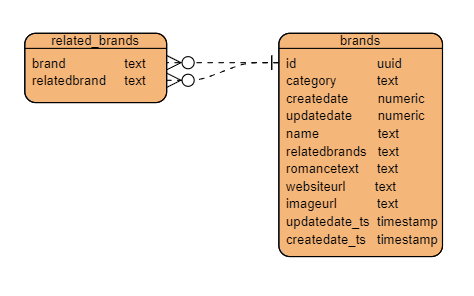

In [31]:
# create brand_codes table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS brand_codes')

c.execute("""CREATE TABLE IF NOT EXISTS brand_codes (
        id uuid PRIMARY KEY,
        brandcode text,
        cpg_id uuid      
    )""")

df_brand_codes.to_sql('brand_codes', conn, if_exists='append', index=False)

conn.commit()
conn.close()

In [32]:
# scratch pad to quick check tables are correct

# table_name = 'products'
# table_name = 'cpgs'
# table_name = 'brands'
# table_name = 'brand_codes'
table_name = 'related_brands'

query=f"""
pragma table_info({table_name})
"""

# query=f"""
#     select 
#         * 
#     from 
#         {table_name};
# """



conn = sqlite3.connect(db_path)
c = conn.cursor()

df = pd.read_sql_query(query,conn)

conn.commit()
conn.close()

df

,cid,name,type,notnull,dflt_value,pk
0,0,brand,TEXT,0,None,0
1,1,relatedbrand,TEXT,0,None,0
